# Машинное обучение

# Лабораторная работа №3

Выполнил студент группы 15-В-1
Коротаев И. А.
Вариант №12

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import (cross_val_score, StratifiedKFold,
                                     train_test_split)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from scipy.stats import pearsonr, spearmanr

# 1.Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).

#### Данные описывают потребление топлива в милях на галон (mpg) у разных автомобилей, что должно быть предсказано с точки зрения 3-х многозначных дискретных и 5-и вещественных атрибутов

|  Переменная  | Описание            | Параметр           |
|:------------:|---------------------|--------------------|
| mpg          | потребление топлива | вещественный       |
| cylinders    | число цилиндров     | дискретный         |
| displacement | литраж              | вещественный       |
| horsepower   | мощность            | вещественный       |
| weight       | вес                 | вещественный       |
| acceleration | ускорение           | вещественный       |
| model year   | год выпуска         | дискретный         |
| origin       | место производства  | дискретный         |
| car name     | название модели     | строка(уникальная) |

Можно убрать столбец car name из датасета, так как он не пригодится при решении задачи регрессии
Исходный датасет был представлен в таком виде, что его пришлось видоизменить для возможности считытвания

In [4]:
# исходные данные
df_name = r'D:\My\MO\LB3\6_mpg\auto-mpg.data.txt'
# видоизмененный датасет
new_df_name = r'D:\df.txt'
# заголовок, который будет добавлен в новый датасет
header = 'mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name\n'

with open(df_name, 'r', newline='') as read_file, \
         open(new_df_name, 'w', newline='') as write_file:
    list_lines = read_file.readlines()
    # пробежимся по строкам в исходном файле
    for i, line in enumerate(list_lines):
        # заменим знаки табуляции на запятые
        list_lines[i] = line.replace('\t', ',')
        # заменим подряд идущие пробелы на запятые
        max_spaces = 7
        for spaces_number in reversed(range(2, max_spaces)):
            spaces = ' '*spaces_number
            list_lines[i] = list_lines[i].replace(spaces, ',')
        list_lines[i] = list_lines[i].replace('?', '')
        list_lines[i] = list_lines[i].replace(',,', ',')
    # запишем полученные строки и заголовок в новый файл
    write_file.write(header)
    write_file.writelines(list_lines)

In [8]:
df = pd.read_csv(new_df_name, sep=',')
df.drop('car name', axis=1, inplace=True)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [9]:
print('dataset size: ', df.shape)
df.count()

dataset size:  (398, 8)


mpg             398
cylinders       398
displacement    398
horsepower      392
weight          398
acceleration    398
model year      398
origin          398
dtype: int64

# 2.Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции

In [10]:
df = df.drop_duplicates()
df = df.dropna().reset_index(drop=True)
print('dataset size: ', df.shape)

dataset size:  (392, 8)


# 3. Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию)

In [13]:
# выделим категориальные и числовые(количественные) признаки
numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']
categorial:  []


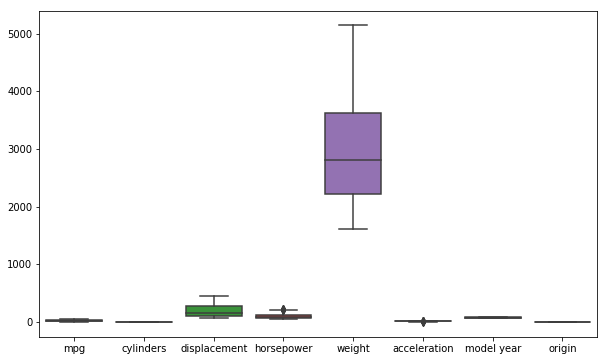

In [14]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df[numerical_columns])
plt.show()

Место производства обозначено через ключи, поэтому оно должно относится к категориальным признакам. Количество цилиндров имеет несколько типов, промежуточные значения не допускаются. Преобразуем эти столбцы к строковому виду

In [22]:
df['cylinders'] = df['cylinders'].apply(lambda x: str(x))
df['origin'] = df['origin'].apply(lambda x: str(x))

#заново выделим категориальные и числовые
numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year']
categorial:  ['cylinders', 'origin']


В качестве способа масштабирования выберем метод нормализации

In [23]:
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,0.239362,8,0.617571,0.456522,0.536150,0.238095,0.0,1
1,0.159574,8,0.728682,0.646739,0.589736,0.208333,0.0,1
2,0.239362,8,0.645995,0.565217,0.516870,0.178571,0.0,1
3,0.186170,8,0.609819,0.565217,0.516019,0.238095,0.0,1
4,0.212766,8,0.604651,0.510870,0.520556,0.148810,0.0,1


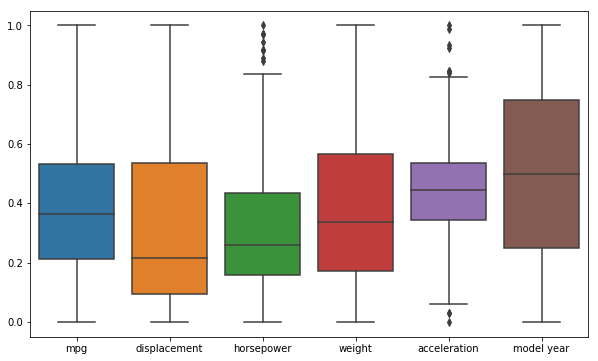

In [24]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df[numerical_columns])
plt.show()

# 4. Выполните замену категориальных признаков; выберите и обоснуйте способ замены

In [28]:
# выведем уникальные значения 
for i in categorial_columns:
    print(i,': ', df[i].unique())

cylinders :  ['8' '4' '6' '3' '5']
origin :  ['1' '3' '2']


In [29]:
df_categorial = pd.get_dummies(df[categorial_columns])
df.drop(categorial_columns, axis=1, inplace=True)
df = pd.concat([df_categorial, df] , axis=1)

print(df.shape)
df.head()

(392, 14)


,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,origin_1,origin_2,origin_3,mpg,displacement,horsepower,weight,acceleration,model year
0,0,0,0,0,1,1,0,0,0.239362,0.617571,0.456522,0.536150,0.238095,0.0
1,0,0,0,0,1,1,0,0,0.159574,0.728682,0.646739,0.589736,0.208333,0.0
2,0,0,0,0,1,1,0,0,0.239362,0.645995,0.565217,0.516870,0.178571,0.0
3,0,0,0,0,1,1,0,0,0.186170,0.609819,0.565217,0.516019,0.238095,0.0
4,0,0,0,0,1,1,0,0,0.212766,0.604651,0.510870,0.520556,0.148810,0.0


# 5. Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других

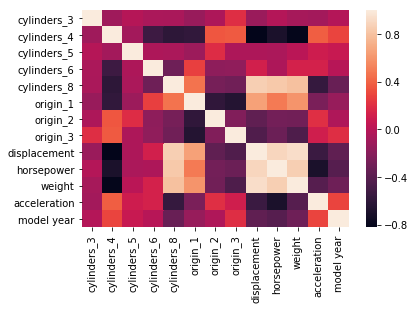

In [30]:
df_corr = df.drop('mpg', axis=1).corr()
sns.heatmap(df_corr)
plt.show()

In [31]:
df_corr

,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,origin_1,origin_2,origin_3,displacement,horsepower,weight,acceleration,model year
cylinders_3,1.000000,-0.103101,-0.008917,-0.052623,-0.060616,-0.131081,-0.046515,0.202103,-0.118441,-0.013786,-0.069310,-0.084436,-0.013236
cylinders_4,-0.103101,1.000000,-0.089173,-0.526269,-0.606202,-0.583651,0.356833,0.367556,-0.823346,-0.691741,-0.804941,0.383486,0.289958
cylinders_5,-0.008917,-0.089173,1.000000,-0.045514,-0.052427,-0.113373,0.191692,-0.044119,-0.041520,-0.050568,0.013018,0.098549,0.072097
cylinders_6,-0.052623,-0.526269,-0.045514,1.000000,-0.309407,0.272473,-0.171470,-0.166979,0.118767,-0.039952,0.137179,0.134093,-0.003914
cylinders_8,-0.060616,-0.606202,-0.052427,-0.309407,1.000000,0.462429,-0.273496,-0.299924,0.860257,0.835989,0.800244,-0.560300,-0.336981
origin_1,-0.131081,-0.583651,-0.113373,0.272473,0.462429,1.000000,-0.591434,-0.648583,0.655936,0.489625,0.600978,-0.258224,-0.136065
origin_2,-0.046515,0.356833,0.191692,-0.171470,-0.273496,-0.591434,1.000000,-0.230157,-0.371633,-0.284948,-0.293841,0.208298,-0.037745
origin_3,0.202103,0.367556,-0.044119,-0.166979,-0.299924,-0.648583,-0.230157,1.000000,-0.440825,-0.321936,-0.447929,0.115020,0.199841
displacement,-0.118441,-0.823346,-0.041520,0.118767,0.860257,0.655936,-0.371633,-0.440825,1.000000,0.897257,0.932994,-0.543800,-0.369855
horsepower,-0.013786,-0.691741,-0.050568,-0.039952,0.835989,0.489625,-0.284948,-0.321936,0.897257,1.000000,0.864538,-0.689196,-0.416361


По диаграмме видно, что литраж сильно коррелирует с мощностью, весом, и ускорением. Поэтому удалим этот параметр из датасета

In [32]:
df.drop('displacement', axis=1, inplace=True)

# 6. Заполните пропущенные значения в данных

In [40]:
print('dataset size: ', df.shape)
df.count()

dataset size:  (392, 13)


cylinders_3     392
cylinders_4     392
cylinders_5     392
cylinders_6     392
cylinders_8     392
origin_1        392
origin_2        392
origin_3        392
mpg             392
horsepower      392
weight          392
acceleration    392
model year      392
dtype: int64

# 7.Решите поставленную задачу регрессии в соответствии с заданием

1. Линейная регрессия без использования регуляризаторов
2. Линейная регрессия, RIDGE регуляризатор

In [41]:
# разделим полученные данные на данные для обучения и теста
X, y = df.drop('mpg', axis=1), df['mpg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Линейная регрессия без использования регуляризаторов

In [42]:
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)
pred_regr = regr.predict(X_test)
print(pred_regr[:15] - y_test[:15])

78     0.036154
274    0.141944
246   -0.038860
55    -0.013163
387    0.050573
203    0.076956
42    -0.099059
233    0.132345
150    0.006503
116    0.036200
9     -0.073881
208    0.128574
287    0.009864
165    0.030097
275    0.132974
Name: mpg, dtype: float64


In [43]:
corr = {}
corr['pearson'], _ = pearsonr(pred_regr, y_test)
corr['spearman'], _ = spearmanr(pred_regr, y_test)
print('pearson correlation: ', corr['pearson'])
print('spearmen correlation: ', corr['spearman'])

pearson correlation:  0.921980379433
spearmen correlation:  0.948606682706


Линейная регрессия, RIDGE регуляризатор

In [45]:
import warnings
warnings.filterwarnings("ignore")

regr = linear_model.Ridge()
params = {'alpha': np.arange(0, 3, 0.05)}
regr_grid = GridSearchCV(regr, params)
regr_grid.fit(X_train, y_train)
best_alpha = regr_grid.best_estimator_.alpha
print('best alpha:', best_alpha)

best alpha: 0.25


In [46]:
regr = linear_model.Ridge(alpha=best_alpha)
regr.fit(X_train,y_train)
pred_regr = regr.predict(X_test)
print(pred_regr[:15] - y_test[:15])

78     0.035924
274    0.147798
246   -0.041637
55    -0.014783
387    0.057387
203    0.078698
42    -0.093571
233    0.135064
150    0.005453
116    0.031890
9     -0.078107
208    0.124958
287    0.009155
165    0.032157
275    0.131835
Name: mpg, dtype: float64


In [51]:
corr = {}
corr['pearson'], _ = pearsonr(pred_regr, y_test)
corr['spearman'], _ = spearmanr(pred_regr, y_test)
print('pearson correlation: ', corr['pearson'])
print('spearmen correlation: ', corr['spearman'])

pearson correlation:  0.92124949167
spearmen correlation:  0.947618266896
